In [195]:
    import notebook.services.contents.filemanager, pandas, pathlib, nbformat, parse, matplotlib, networkx

In [108]:
    read = lambda str: pathlib.Path(str).read_text(encoding='utf-8')

In [177]:
    df = pandas.DataFrame(notebook.services.contents.filemanager.FileContentsManager().get('')).pipe(
        lambda df: df.content.apply(pandas.Series).join(df, rsuffix='_')
    ).pipe(lambda df: df[df.path.str.endswith('.ipynb')])
    df[['last_modified', 'created']] = df[['last_modified', 'created']].apply(pandas.to_datetime, axis=0)
    df = df.set_index(['created', 'name'])

In [178]:
    df = df.path.apply(lambda str: nbformat.v4.reads(read(str))).apply(pandas.Series).pipe(
        lambda df: df['cells'].apply(pandas.Series).stack().apply(pandas.Series).reset_index(-1).join(df, rsuffix='_')
    ).set_index('level_2', append=True)

The correspondence between Markdown and Code cells in deathbeds posts.

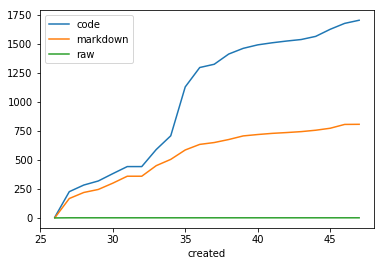

In [200]:
    df.cell_type.pipe(pandas.get_dummies).groupby(pandas.Grouper(freq='1W', level=0)).sum().pipe(
        lambda s: s.set_index(s.index.week)).cumsum().plot();

In [197]:
    queries = ['deathbeds.{} ', 'from deathbeds import {} ', "__import__('deathbeds.{}')"]
    for query in queries: df[query] = df.source.apply(
        lambda x: list(parse.findall(query, x))).pipe(lambda df: df[df.apply(bool)])

One of the key features of deathbeds is the fuzzy query import language provided by importnb in the post names.  Early on deathbeds realized we needed a permissive naming system that could can important a variety of naming systems.

In [199]:
    connections = df[queries].stack().apply(lambda x: pandas.Series(unique(x.fixed[0].strip() for x in x))).stack().apply(
        excepts(BaseException, lambda str: importnb.finder.fuzzy_file_search('', str)[0])
    ).apply(pandas.Series).dropna(how='all').reset_index(-1, drop=True).reset_index(-1, drop=True).reset_index(
        -1, drop=True
    )[0].rename('source').to_frame().reset_index('name')

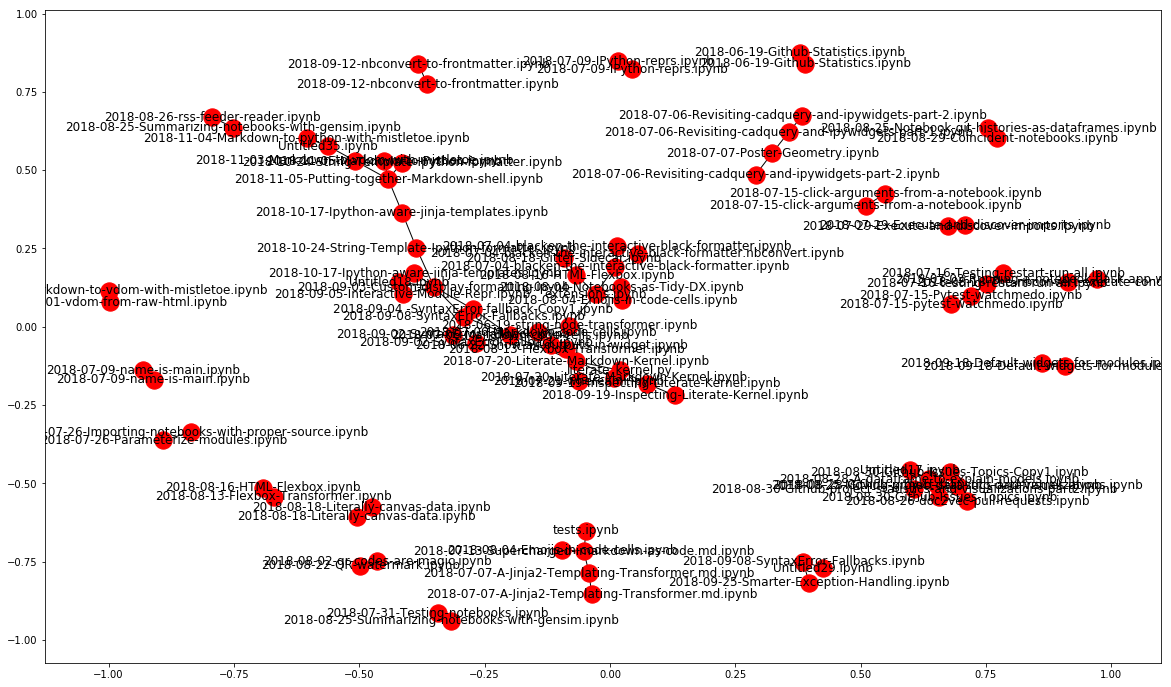

In [194]:
    networkx.draw_networkx(connections.pipe(networkx.from_pandas_edgelist, target='name'))
    matplotlib.pyplot.gcf().set_size_inches(20, 12)